## Project: 
## Optimizing Wholesale Wine business by segmenting customers behavior using Machine Learning - Kmeans powered by Tableau


![wine](https://user-images.githubusercontent.com/67468718/108137243-5c2c7e80-7070-11eb-91c4-b61cf5d2712b.JPG)



## Contents 

**1. Introduction**


**2. Dataset & Objective**


**3. Sourcing and loading**
   * Import packages
   * Load the data
   * Explore the data


**4. Cleaning, transforming and visualizing**
   * Data Wrangling: 
        * Creating a matrix with a binary indicator for whether they responded to a given offer
        * Ensure that in doing so, NAN values are dealt with appropriately
    

**5. Modelling** 
   * Dataset (Offers) Visualization
   * K-Means Clustering (Choosing K)
        * Choosing K: The Elbow method
            * Distortion (Euclidean distance metric is used)
            * Inertia (inertia_ attribute from kmeans is used)
            * Sum-of-squares error (SSE) in each cluster against K
        * Choosing K: The Silhouette method
        * Choosing K: The Gap statistic method
    
   * Visualizing clusters with PCA

**6. Conclusions**
   * kmeans with best <code>**k=4**</code>
   * Add kmeans cluster assignments to the main DataFrame "merged" 
   * Save our final data For EDA powered by <code>**Tableau**</code>
   * Conclusions and Business Recommendations Powered by <code>**ML K-means**</code> and <code>**Tableau Dashboards**</code>
   
**7. Clustering Algorithms in Scikit-learn**
   * Affinity propagation
   * Spectral clustering
   * Agglomerative clustering
   * DBSCAN





## 1. Introduction

This project is based on a book called [Data Smart](https://www.amazon.com/Data-Smart-Science-Transform-Information/dp/111866146X), written by John Foreman, head of product for MailChimp. This book is an excellent business analytics primer that walks you through a variety of machine learning use cases, complete with sample data sets and detailed instructions on how to set up and solve each case in Excel. 

One of these cases, John describes a fictitious wholesale wine business looking to optimize sales by segmenting customers — restaurant and liquor store owners, into groups based on buying behavior. This is a very common problem faced by all kinds of businesses from large retailers like Walmart and Target to your friendly neighborhood liquor store.

## 2. Dataset & Objective

The data set provided includes two files [Location](https://community.alteryx.com/t5/Data-Science/Beginner-s-Guide-to-Customer-Segmentation/ba-p/138442), one listing about three dozen product discount offers made over the course of a year, and the other listing customers and their purchase details. <Code>**Our objective is to figure out which customers would be most attracted to which types of discount offers going forward.**</Code> This is a classic customer segmentation or clustering problem.
Each discount offer is described with six attributes — Month, Wine Varietal, Minimum Quantity, Discount %, Country of Origin and Past Peak (T/F). There are 32 different offers listed, each with a different combination of these attributes. The customer list includes 324 transactions for about 100 customers. So this challenge involves many more dimensions than you typically see in a machine learning tutorial for clustering.

## 3. Sourcing and loading
### 3.1 Import packages

In [2]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

### 3.2 Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [3]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

In [4]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]

We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [5]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1

### 3.3 Explore the data

In [6]:
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


In [7]:
df_offers.shape

(32, 7)

In [8]:
df_offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   offer_id   32 non-null     int64 
 1   campaign   32 non-null     object
 2   varietal   32 non-null     object
 3   min_qty    32 non-null     int64 
 4   discount   32 non-null     int64 
 5   origin     32 non-null     object
 6   past_peak  32 non-null     bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 1.7+ KB


In [9]:
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


In [10]:
df_transactions.shape

(324, 3)

In [11]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customer_name  324 non-null    object
 1   offer_id       324 non-null    int64 
 2   n              324 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.7+ KB


## 4. Cleaning, transforming and visualizing
### 4.1 Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

In [12]:
# Alright, now let's merge the above Dataframes: df_transactions & df_offers on=offer_id:
merged = df_transactions.merge(df_offers, on='offer_id')
merged.shape

(324, 9)

In [13]:
# confirm the data structure"
merged.head()

,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak
0,Smith,2,1,January,Pinot Noir,72,17,France,False
1,Rodriguez,2,1,January,Pinot Noir,72,17,France,False
2,Martin,2,1,January,Pinot Noir,72,17,France,False
3,Jackson,2,1,January,Pinot Noir,72,17,France,False
4,Campbell,2,1,January,Pinot Noir,72,17,France,False


In [14]:
#We now want to make a pivot table, to show a matrix with customer names in the row index and offer numbers as columns headers
#and fill NANs with zeros

pivoted = merged.pivot_table(index='customer_name', columns='offer_id', values='n', fill_value=0)
pivoted

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Williams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Wilson,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
Wood,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [15]:
# Now, let's check the final datatypes and shape
pivoted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, Adams to Young
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   1       100 non-null    int64
 1   2       100 non-null    int64
 2   3       100 non-null    int64
 3   4       100 non-null    int64
 4   5       100 non-null    int64
 5   6       100 non-null    int64
 6   7       100 non-null    int64
 7   8       100 non-null    int64
 8   9       100 non-null    int64
 9   10      100 non-null    int64
 10  11      100 non-null    int64
 11  12      100 non-null    int64
 12  13      100 non-null    int64
 13  14      100 non-null    int64
 14  15      100 non-null    int64
 15  16      100 non-null    int64
 16  17      100 non-null    int64
 17  18      100 non-null    int64
 18  19      100 non-null    int64
 19  20      100 non-null    int64
 20  21      100 non-null    int64
 21  22      100 non-null    int64
 22  23      100 non-null    int64
 23  24      100 no

In [16]:
#Let's check how many customers responded per offer:
pivoted.sum().sort_values(ascending=False)

offer_id
30    22
22    21
8     20
7     19
29    17
31    17
26    15
18    14
11    13
4     12
6     12
24    12
9     10
1     10
2     10
14     9
27     9
17     7
10     7
3      6
15     6
13     6
25     6
28     6
20     6
16     5
12     5
19     5
23     5
5      4
21     4
32     4
dtype: int64

## 5. Modelling: 
### 5.1 Dataset (Offers) Visualization:
##### using PCA for dimension reductions ndarray to 2darray:



Text(0.5, 1.0, 'Offers in 2-Dimensional')

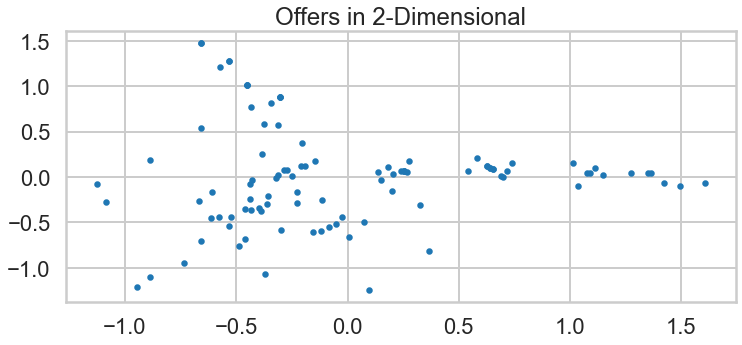

In [17]:
### Let's use PCA so we can viusalize our offers into a 2-dimensional form: 

# Import the PCA class function from sklearn
from sklearn.decomposition import PCA

# Cast your table 'pivoted' as a matrix with to_numpy(), and store it in a variable X 
# Let's keep only the offers in X:
X = pivoted.iloc[:,1:].to_numpy()

# Transform the offers using two principal components
pca = PCA(n_components=2, random_state=2018)
p_comps = pca.fit_transform(X)

# Extract the first and second component to use for the scatter plot
p_comp1 = p_comps[:, 0]
p_comp2 = p_comps[:, 1]

# Plot the first two principal components in a scatter plot
plt.subplots(figsize=(12, 5))
plt.scatter(p_comp1, p_comp2, s=20, marker='o')
plt.title("Offers in 2-Dimensional")

### 5.2 K-Means Clustering (Choosing K)

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 5.2.1 Choosing $K$: The Elbow Method

The Elbow Method is one of the most popular methods to determine this optimal value of k.

From the above visualization, we can see that the optimal number of clusters should be between 3-5. But visualizing the data alone cannot always give the right answer. Hence we demonstrate the following steps.

Now, let's define the following:-

 * **Distortion:** It is calculated as the average of the squared distances from the cluster centers of the respective clusters. Typically, **the Euclidean distance metric is used.**
 * **Inertia:** It is the sum of squared distances of samples to their closest cluster center. Typically, **inertia_ attribute from kmeans is used.**
 * Lastly, we look at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 


Let's now iterate the values of k from 2 to 10 and calculate the values of distortions for each value of k and calculate the distortion and inertia for each value of k in the given range:

In [18]:
# let's import all the necessary libraries:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import numpy as np

# Now. let's Initilize distortions, inertias, mapping1 and mapping2:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}

#Initilize our clusters ranges:
K = range(2, 11)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, random_state=2018).fit(p_comps)
    kmeanModel.fit(p_comps)
 
    distortions.append(sum(np.min(cdist(p_comps, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / p_comps.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(p_comps, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / p_comps.shape[0]
    mapping2[k] = kmeanModel.inertia_

#### 5.2.1.1 Elbow Method - Distortion from scipy

2 : 0.5378536943951695
3 : 0.3790481571768376
4 : 0.32809885714315745
5 : 0.2802277815521924
6 : 0.25176554615644464
7 : 0.23006314630235866
8 : 0.20946934676161466
9 : 0.17336725067095873
10 : 0.15746174920494047


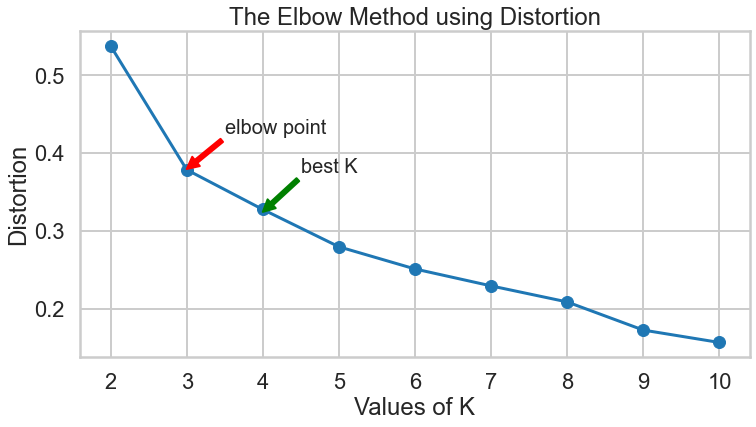

In [19]:
# let's iterate over mapping1 to get the avg verage of the squared distances from the cluster centers:
for key, val in mapping1.items():
    print(f'{key} : {val}')
    
# let's visualize elbow point and best K:
plt.subplots(figsize=(12, 6))    
plt.plot(K, distortions, marker='o')
plt.annotate('elbow point', xy=(3, 0.38), xytext=(3.5, 0.425), arrowprops={'color':'red'}, fontsize=20)
plt.annotate('best K', xy=(4, 0.325), xytext=(4.5, 0.375), arrowprops={'color':'green'}, fontsize=20)
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

**Elbow Method using Distortion from Scipy** confirms that the <code>**elbow point k=3**</code> so the <code>**best k will be=4**</code> (plot starts descending much more slowly after k=3)

#### 5.2.1.2 Elbow Method - Inertia  from kmeans

2 : 41.1757607231306
3 : 19.93505132348969
4 : 13.983939187351986
5 : 10.204561507615278
6 : 8.484422566732423
7 : 6.72805369578606
8 : 5.633706031344305
9 : 4.525788252425146
10 : 3.5980293097371314


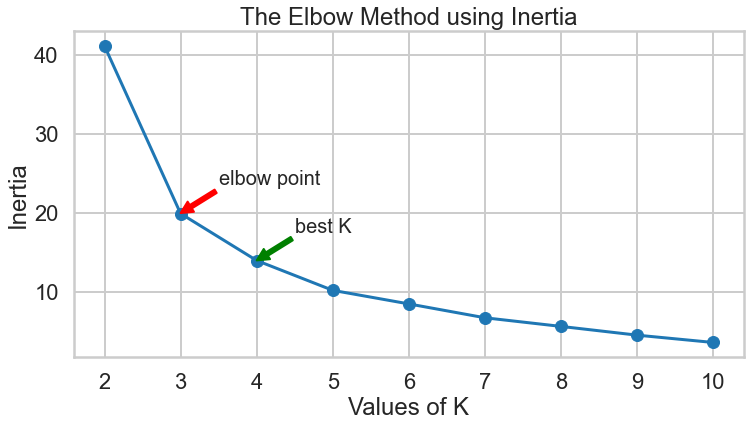

In [20]:
# let's iterate over mapping2 to get the sum of squared distances of samples to their closest cluster center (inertia)
for key, val in mapping2.items():
    print(f'{key} : {val}')

# let's visualize elbow point and best K:
plt.subplots(figsize=(12, 6)) 
plt.plot(K, inertias, marker='o')
plt.annotate('elbow point', xy=(3, 20), xytext=(3.5, 23.5), arrowprops={'color':'red'}, fontsize=20)
plt.annotate('best K', xy=(4, 14), xytext=(4.5, 17.5), arrowprops={'color':'green'}, fontsize=20)
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()    

**Elbow Method using Inertia from kmeans** confirms that the <code>**elbow point k=3**</code> so the <code>**best k will be=4**</code> (plot starts descending much more slowly after k=3)

#### 5.2.1.3 Elbow Method - sum-of-squares error (SSE)

Text(0, 0.5, 'Sum of Squares - SSE')

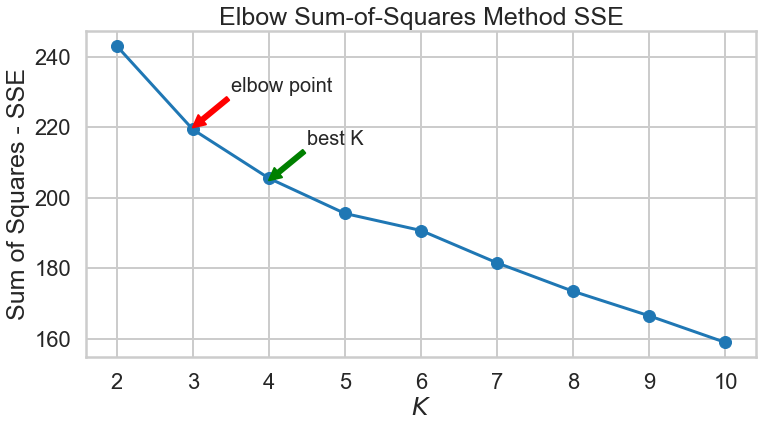

In [21]:
# let's import all the necessary libraries:
from sklearn.cluster import KMeans
import numpy as np

# Make an empty list
ss = []

# Make an empty dictionary called assignments 
assignments = {}

# Make a variable called Krange, and assign it a list of range(2, 11)
Krange  = list(range(2, 11))

# We now want to iterate through this list to construct a plot showing SS for each K. Name the iterator variable K 
for K in Krange:
    # Make a variable called model, and assign it the result of calling sklearn.cluster.KMeans, with n_clusters = K 
    model = KMeans(n_clusters=K, random_state=2018)
    assigned_cluster = model.fit_predict(X)
    centers = model.cluster_centers_
    ss.append(np.sum((X - centers[assigned_cluster]) ** 2))
    assignments[str(K)] = assigned_cluster
    
# Call plot() on plt with parameters Krange and ss
plt.subplots(figsize=(12, 6))
plt.plot(Krange, ss, marker='o', linewidth=3)

# Let's label the plot 
plt.annotate('elbow point', xy=(3, 220), xytext=(3.5, 230), arrowprops={'color':'red'}, fontsize=20)
plt.annotate('best K', xy=(4, 205), xytext=(4.5, 215), arrowprops={'color':'green'}, fontsize=20)
plt.title('Elbow Sum-of-Squares Method SSE', fontsize=25)
plt.xlabel("$K$", fontsize=25)
plt.ylabel("Sum of Squares - SSE", fontsize=25)

Unfortunately, from last method, this plot doesn’t show a real clear “elbow point”, which means it is not straightforward to find the number of clusters using this Sum-of-Squares (SSE) Method. however, from above we can see that <code>k=3 is our most obvious elbow point</code>, Thus <code>best option for K will be 4</code> **(plot starts descending much more slowly after k=3).**

4


([<matplotlib.axis.XTick at 0x1900cc69288>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

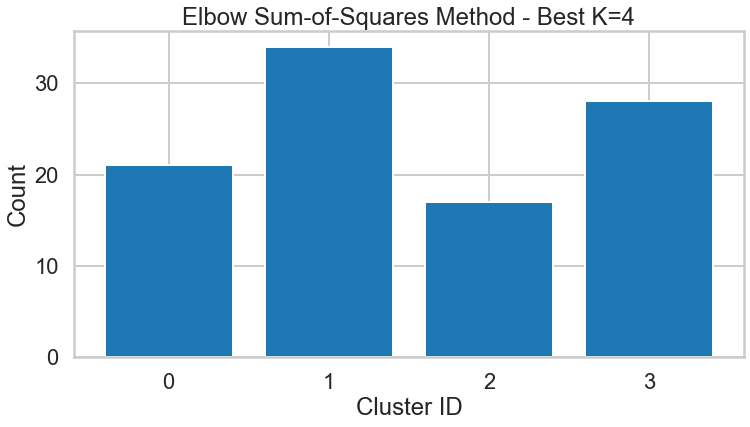

In [22]:
# What is the best K? Fill in the assignment below appropriately
best_K = 4
assignments_best_K = assignments[str(best_K)]
counts = np.bincount(assignments_best_K)
print(len(counts))

# Call bar() on plt, with parameters range(best_K), counts, and align = 'center'
plt.subplots(figsize=(12, 6))
plt.bar(range(best_K), counts, align = 'center')

# Label the axes 
plt.title("Elbow Sum-of-Squares Method - Best K=4")
plt.xlabel("Cluster ID")
plt.ylabel("Count")
plt.xticks(range(best_K))

#### 5.2.2 Choosing $K$: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.



| Range       | Interpretation                                |
|:-------------|:-----------------------------------------------:|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |


[Source](http://www.stat.berkeley.edu/~spector/s133/Clus.html)

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

For n_clusters = 2 The average silhouette_score is : 0.407635404305993
For n_clusters = 3 The average silhouette_score is : 0.5285820486788562
For n_clusters = 4 The average silhouette_score is : 0.44567045478320155
For n_clusters = 5 The average silhouette_score is : 0.4774548333317686
For n_clusters = 6 The average silhouette_score is : 0.4571034515767603
For n_clusters = 7 The average silhouette_score is : 0.47095043975478407
For n_clusters = 8 The average silhouette_score is : 0.4749117623093867
For n_clusters = 9 The average silhouette_score is : 0.5113204460650579
For n_clusters = 10 The average silhouette_score is : 0.5311689210421009


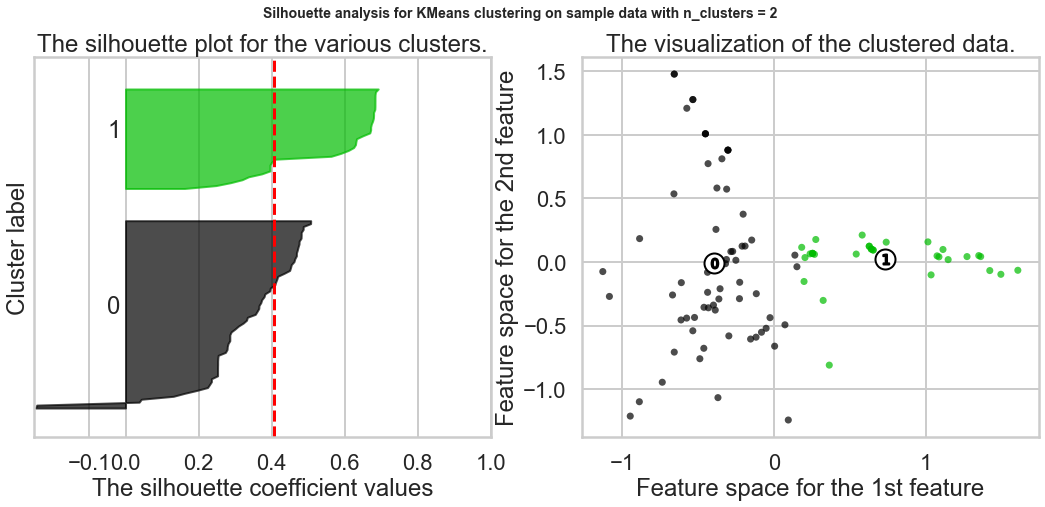

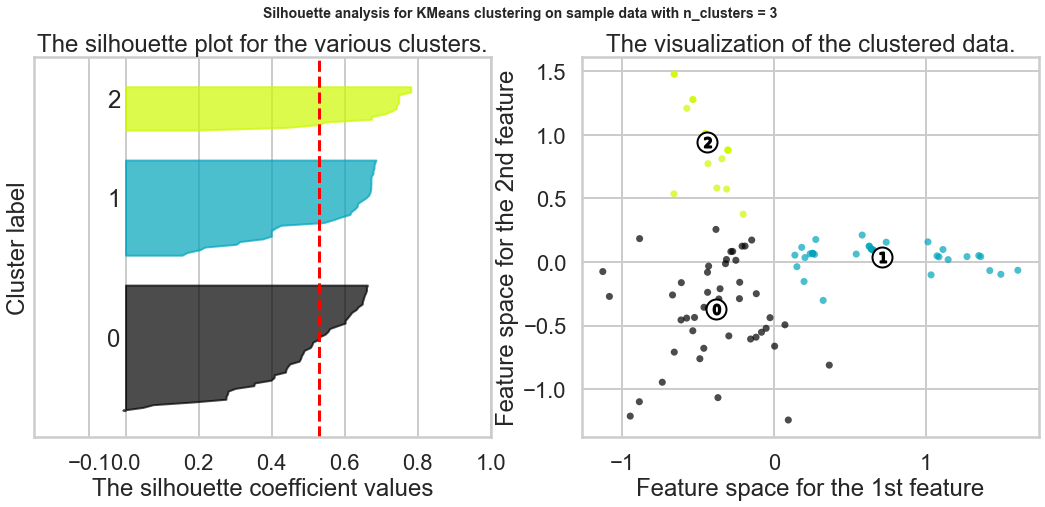

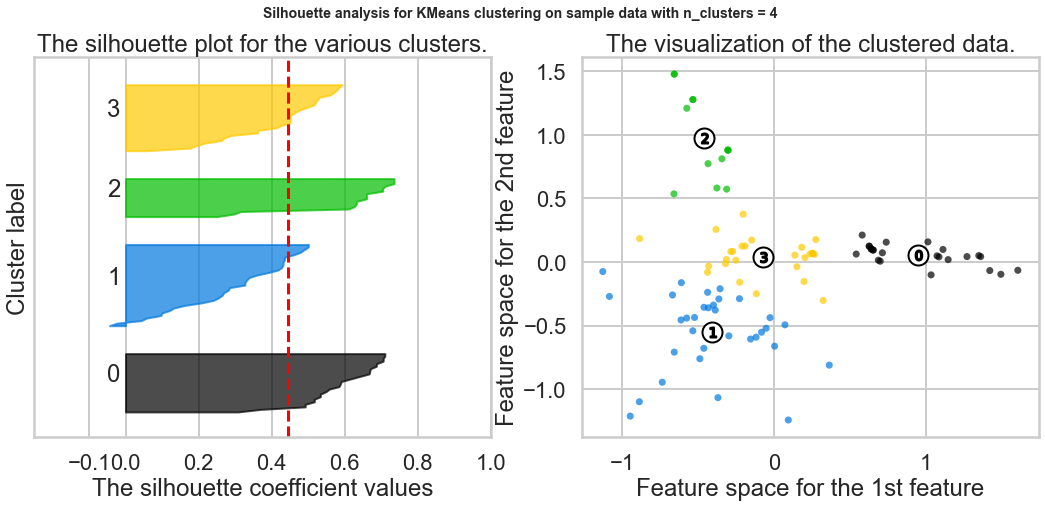

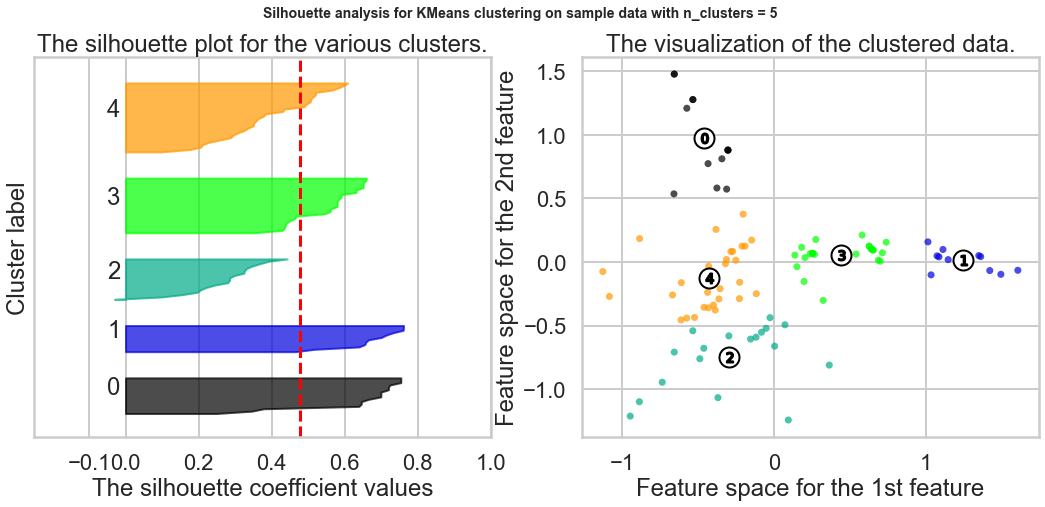

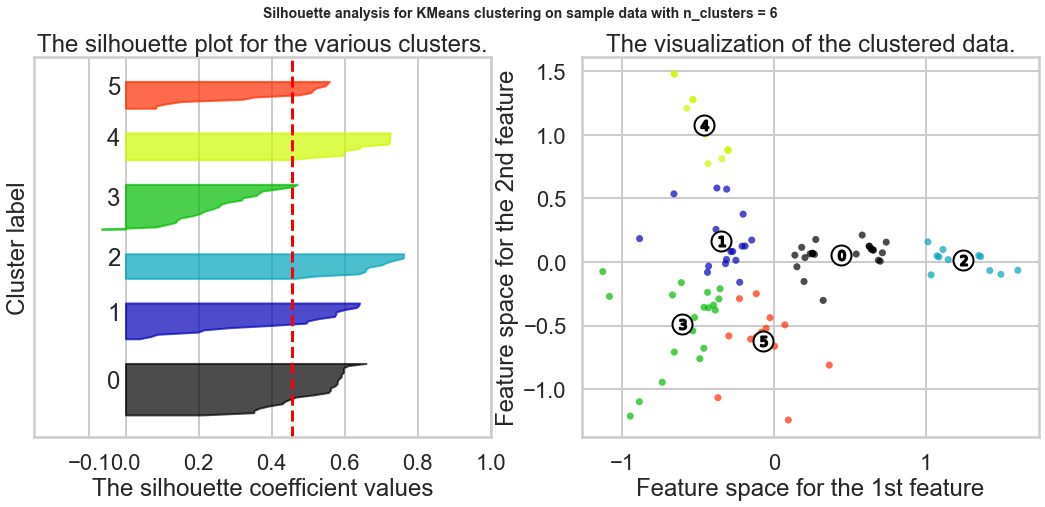

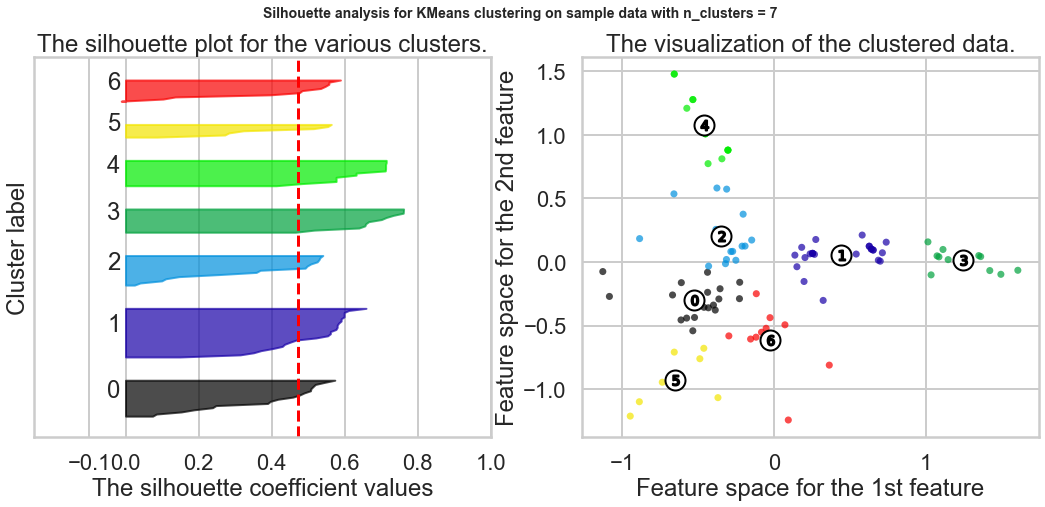

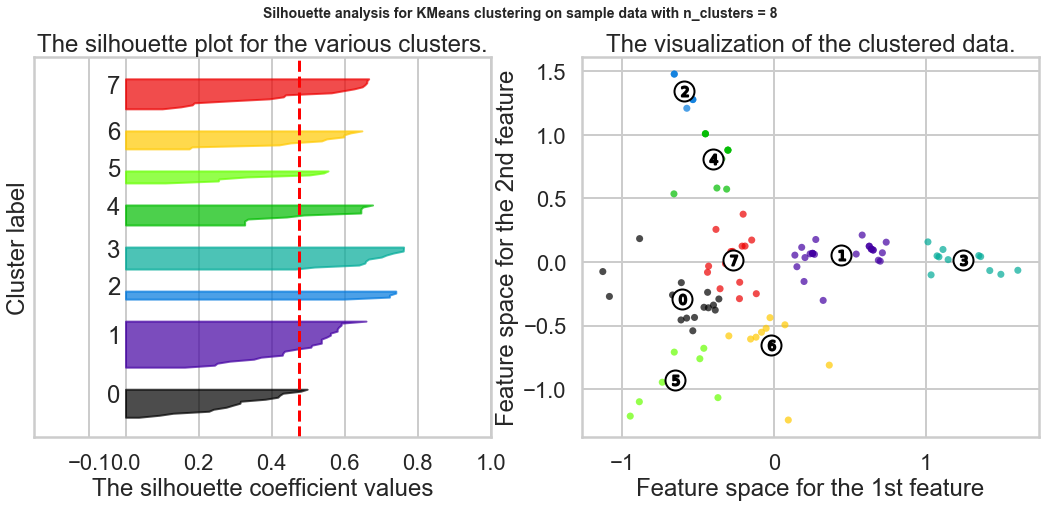

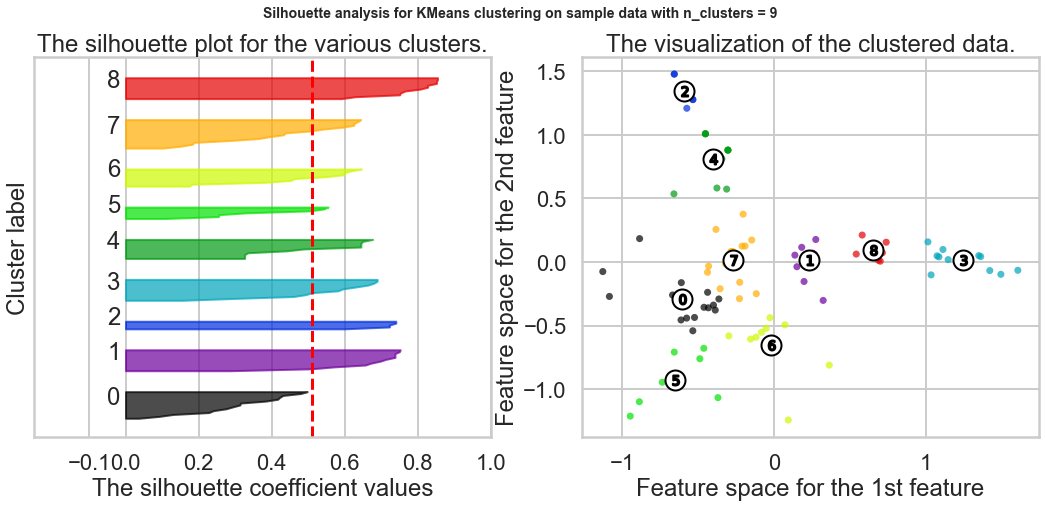

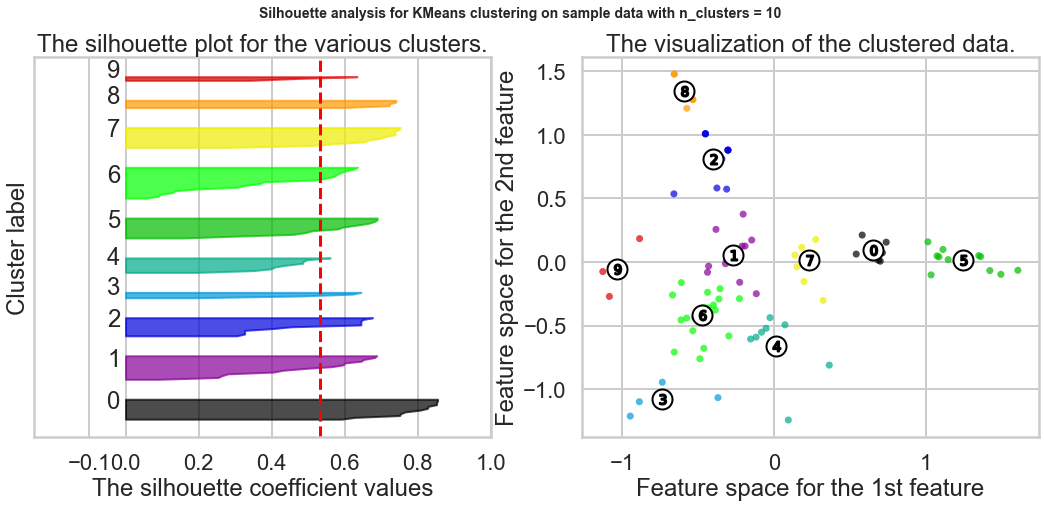

In [23]:
# OUR SOURCE: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

# let's import all the necessary libraries:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm


# Make an empty list called avg_silhouette_scores
avg_silhouette_scores = []

# Iterate through Krange with variable K as before
for K in Krange:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
    #ax1.set_xlim([-0.25, 1])
    ax1.set_xlim([-0.25, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (K + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 2018 for reproducibility.
    clusterer = KMeans(n_clusters=K, random_state=2018)
    cluster_labels = clusterer.fit_predict(p_comps)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    # Make a variable called silhouette_avg. Set the parameters to silhouette_score to X, and cluster_labels
    silhouette_avg = silhouette_score(p_comps, cluster_labels)
    avg_silhouette_scores.append(silhouette_avg)
    print("For n_clusters =", K,
          "The average silhouette_score is :", silhouette_avg)    

    # Compute the silhouette scores for each sample
    # Call silhouette_samples with the below parameters
    sample_silhouette_values = silhouette_samples(p_comps, cluster_labels)

    y_lower = 10
    for i in range(K):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        # Make a variable called ith_cluster_silhouette_values
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        # Call sort() on this variable 
        ith_cluster_silhouette_values.sort()
    
        # Call shape[0] on ith_cluster_silhouette_values 
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        #cmap = cm.get_cmap("Spectral")
        color = cm.nipy_spectral(float(i) / K)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        # This requires calling text() on ax1 
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    # Setting title, xlabel and ylabel 
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    # This requires axvline() 
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / K)
    ax2.scatter(p_comp1, p_comp2, marker='.', s=200, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=400, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=100, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")    

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % K),
                 fontsize=14, fontweight='bold')
plt.show()    

Text(0, 0.5, 'Average Silhouette Score')

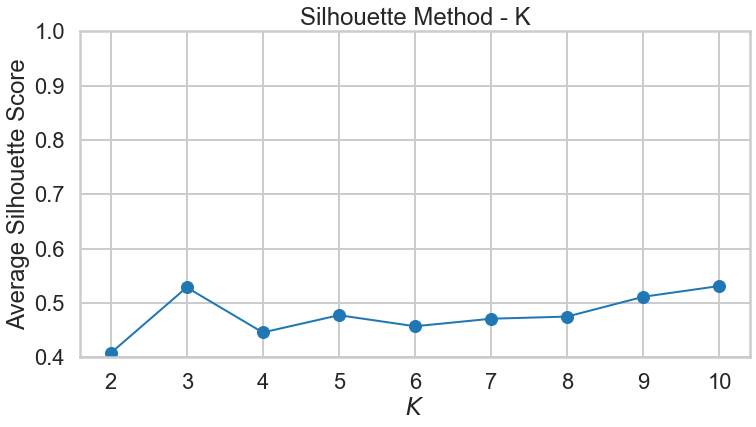

In [25]:
# Computing the avrage silhouette score for each K and plotting it 
# Call plot() with parameters Krange, avg_silhouette_scores
plt.subplots(figsize=(12, 6))
plt.plot(Krange, avg_silhouette_scores, marker='o', linewidth=2)
plt.title("Silhouette Method - K")
plt.ylim(0.40, 1)
plt.xlabel("$K$")
plt.ylabel("Average Silhouette Score")




Again, there does not appear to be a clear way to find best K in this method, which means it is not straightforward to find the number of clusters using this method. however, from above we can see <code>k=10, 3 and 9 </code>are our best option for now **(Closest to 1 = best Silhouette Score, but clearly Silhouette Scores are relatively small suggesting we have a weak structure!!!)**

#### 5.2.3 Choosing $K$: The Gap Statistic Method

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

#### 5.2.4 Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

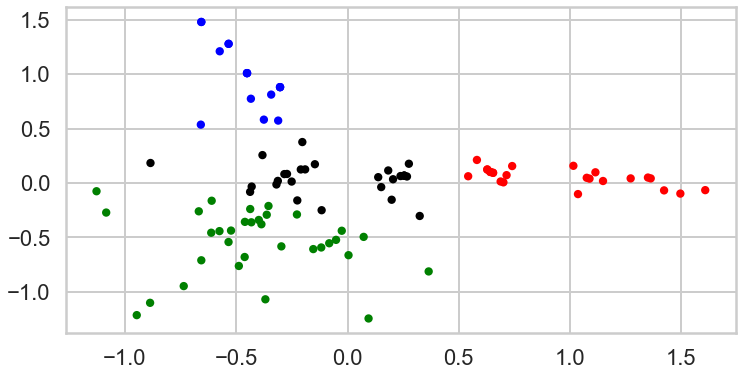

In [102]:
# Let's import matplotlib.colors:
import matplotlib.colors

# Make a variable called model. We want n_clusters = 4 as parameter to sklearn.cluster.KMeans 
model = KMeans(n_clusters=4, random_state=2018)
# Call a fit_predict() on X 
cluster_assignments = model.fit_predict(p_comps)

# Let's visualiaze with colors.ListedColormap
cmap = matplotlib.colors.ListedColormap(['red', 'green', 'blue', 'black'])
plt.subplots(figsize=(12, 6))
plt.scatter(p_comp1, p_comp2, c=cluster_assignments.tolist(), cmap=cmap, s=40)

Let's look at the clusters!

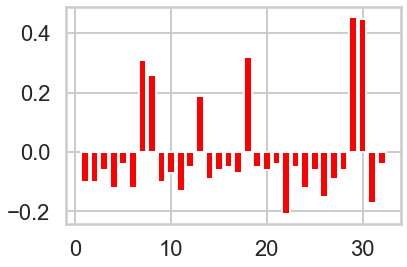

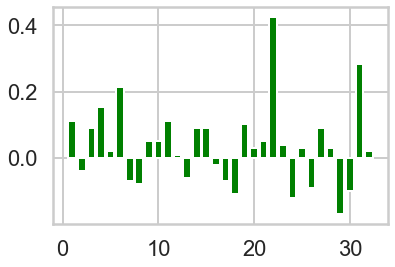

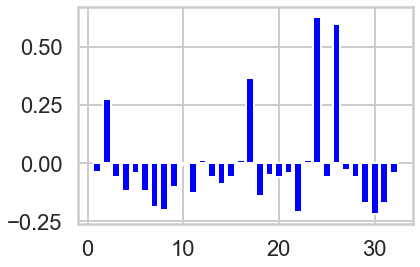

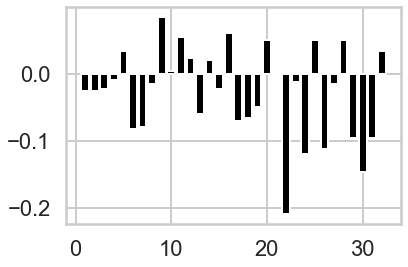

In [106]:
# Plot count of offer_id in each cluster.
# But, certain offers were used more than others in the original data.
# Let's compute the difference between how often they were used in each cluster vs globally.
model = KMeans(n_clusters=4, random_state=2018)
cluster_assignments = model.fit_predict(p_comps)

colors = ['red', 'green', 'blue', 'black']
offer_proportions = pivoted.sum(axis=0) / 100  # There are 100 customers
for i in range(4):
    plt.figure(i)
    cluster = pivoted[cluster_assignments == i]
    offer_proportions_cluster = cluster.sum(axis=0) / cluster.shape[0]  # Number of customers in cluster
    lift = offer_proportions_cluster - offer_proportions
    plt.bar(range(1, 33), lift, color=colors[i])

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

The cumulative variance of the first two principal components is 0.25668


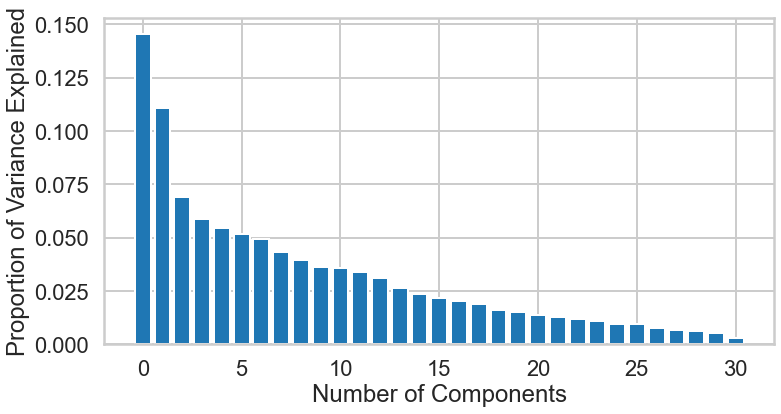

In [28]:
# Initialize a new PCA model with a default number of components.
pca = PCA(random_state=2018)
pca.fit(X)

# Let's finish this :)  Make a variable called variance
variance = pca.explained_variance_ratio_

# Plot() it:
plt.subplots(figsize=(12, 6))
plt.bar(range(len(variance)), variance)

# Label the axes
plt.xlabel("Number of Components")
plt.ylabel("Proportion of Variance Explained")

# Compute the cumulative proportion of variance explained by the first two principal components
two_first_comp_var_exp = pca.explained_variance_ratio_.cumsum()[1]
print("The cumulative variance of the first two principal components is {}".format(
    round(two_first_comp_var_exp, 5)))


## 6. Conclusions
### 6.1 kmeans with best k=4


In [29]:
# Set the number of clusters at 4, and run the k-means algorithm:
n_clusters_final=4
final_model = KMeans(n_clusters=n_clusters_final, random_state=2018).fit(pivoted)

# Generate a list customers with cluster assignments:

df = pd.DataFrame()
df['customer_name'] = pivoted.index.values
df['cluster'] = final_model.labels_

df.head(15)

,customer_name,cluster
0,Adams,0
1,Allen,2
2,Anderson,3
3,Bailey,0
4,Baker,0
5,Barnes,1
6,Bell,3
7,Bennett,0
8,Brooks,1
9,Brown,0


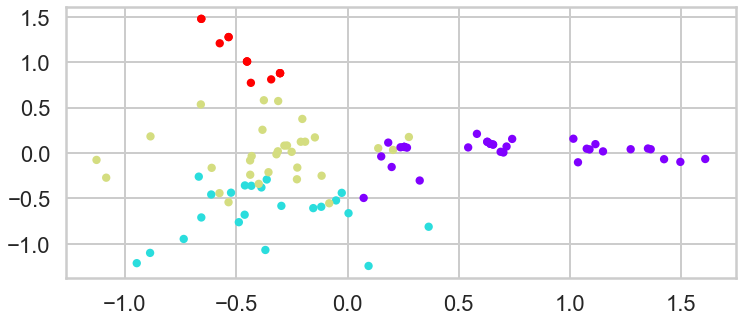

In [53]:
plt.subplots(figsize=(12, 5))
plt.scatter(p_comp1, p_comp2, c=final_model.labels_, s=40, marker='o', cmap='rainbow')

### 6.2 Add kmeans cluster assignments to the main DataFrame "merged" 

In [30]:
# now let's merge clusters to the main dataframe merged:
df_new = df.merge(merged, on='customer_name', how='right')
df_new

,customer_name,cluster,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak
0,Smith,3,2,1,January,Pinot Noir,72,17,France,False
1,Smith,3,24,1,September,Pinot Noir,6,34,Italy,False
2,Rodriguez,3,2,1,January,Pinot Noir,72,17,France,False
3,Rodriguez,3,26,1,October,Pinot Noir,144,83,Australia,False
4,Martin,2,2,1,January,Pinot Noir,72,17,France,False
...,...,...,...,...,...,...,...,...,...,...
319,Ward,2,4,1,February,Champagne,72,48,France,True
320,Allen,2,9,1,April,Chardonnay,144,57,Chile,False
321,Allen,2,27,1,October,Champagne,72,88,New Zealand,False
322,Ramirez,2,9,1,April,Chardonnay,144,57,Chile,False


### 6.3 Let's save our final data so we can start analyzing using Tableau

In [31]:
#let's save the data so we review and analyze using Tableau to see if we can get any insights:
df_new.to_csv(path_or_buf = 'C:/Users/aktha/Desktop/Future/GOALLLLL/1602764303_Clustering_Case_Study_updated_10_15_2020' + "/kmeans_wine_final_4.csv", index=False)

In [36]:
df_new.varietal.unique()

array(['Pinot Noir', 'Cabernet Sauvignon', 'Champagne', 'Malbec',
       'Prosecco', 'Chardonnay', 'Merlot', 'Espumante', 'Pinot Grigio'],
      dtype=object)

|varietal| type|
|:------:|:----:|
|Malbec   |  red wine       |
|Pinot Noir| red wine       |
| Merlot| red wine       |
|Cabernet Sauvignon|red wine        |
|Espumante|sparkling wine        |
|Champagne|sparkling wine        |
|Prosecco |sparkling wine        |
|Chardonnay| White wine       |
|Pinot Grigio| White wine        |


In [37]:
df_new.min_qty.unique()

array([ 72,   6, 144,  12], dtype=int64)

### 6.4 Conclusions and Business Recommendations Powered by ML K-means and Tableau Dashboards

 1. <code>**Cluster_0**</code> represents customers who loves both French Red Wine and Sparkling Wine (89% consumes  >= 72 Min Qty) specifically: Cabernet Sauvignon & Champagne.
 2. <code>**Cluster_1**</code> represents customers who loves Sparkling Wine (75% consumes  >= 72 Min Qty) mainly Champagne but in general they enjoys French sparkling Wine.
 3. Customers from both <code>**Cluster_0**</code> & <code>**Cluster_1**</code> (More than 75% of them, consumes >= 72 Min Qty) , they love Cabernet Sauvignon & Champagne  specially if there’s high Discounts since they’re heavy consumers **(Focus group of customers to increase sales by introducing more Discounts on Cabernet Sauvignon & Champagne)**
 4. <code>**Cluster_2**</code> represents customers who are not heavy Wine consumers (Almost  100% of them, consumes  = 6 Min Qty) but still they enjoys French Wine in general (sparkling, Red, and some white). **(Focus group of customers to increase revenue by introducing more wine varieties because these guys are NOT wine specific who are not settled yet and they would try more or new varieties).**
 5. <code>**Cluster_3**</code> represents customers who loves Red Wine specifically Pinot Noir. These guys will buy Pinot Noir regardless if there’s big Discount or not and they don’t care about the origin either. They’re just Pinot Noir lovers!! **(Focus group of customers to increase revenue by increasing Pinot Noir price!!).**
 
![main](https://user-images.githubusercontent.com/67468718/108069843-af72e280-7018-11eb-85bc-0d04f18e9378.JPG)
![ML_Tableau](https://user-images.githubusercontent.com/67468718/108069846-b0a40f80-7018-11eb-990f-35a9e15c2f5d.JPG) 



## 7. Clustering Algorithms in Scikit-learn:

 * Affinity propagation
 * Spectral clustering
 * Agglomerative clustering
 * DBSCAN
 
 
k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size. 

How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>



### 7.1 Affinity propagation

Affinity Propagation was first published in 2007 by Brendan Frey and Delbert Dueck in Science. In contrast to other traditional clustering methods, Affinity Propagation does not require you to specify the number of clusters. In layman’s terms, in Affinity Propagation, each data point sends messages to all other points informing its targets of each target’s relative attractiveness to the sender. Each target then responds to all senders with a reply informing each sender of its availability to associate with the sender, given the attractiveness of the messages that it has received from all other senders. Senders reply to the targets with messages informing each target of the target’s revised relative attractiveness to the sender, given the availability messages it has received from all targets. The message-passing procedure proceeds until a consensus is reached. Once the sender is associated with one of its targets, that target becomes the point’s exemplar. All points with the same exemplar are placed in the same cluster. [source](https://towardsdatascience.com/unsupervised-machine-learning-affinity-propagation-algorithm-explained-d1fef85f22c8)



In [62]:
# first, let's import the necessary library:
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN

#initialize and train our model
af = AffinityPropagation(random_state=2018)

clustering = af.fit(pivoted)


Text(0.5, 1.0, 'Affinity propagation Clustering')

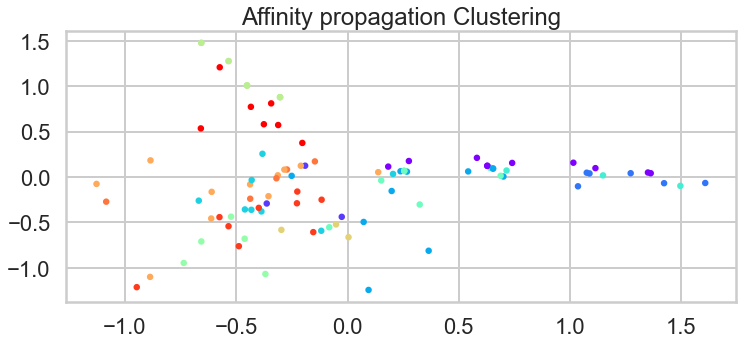

In [81]:
plt.subplots(figsize=(12, 5))
plt.scatter(p_comp1, p_comp2, c=clustering.labels_, s=20, marker='o', cmap='rainbow')
plt.title('Affinity propagation Clustering')


In [60]:
df_af = pd.DataFrame()
df_af['customer_name'] = pivoted.index.values
df_af['cluster'] = clustering.labels_
print("Affinity propagation clustering Algorithm results: ", df_af.cluster.nunique(), "Clusters")

Affinity propagation clustering Algorithm results:  14 Clusters


As shown above, <code>**14 clusters**</code> is a very large number to explain our small dataset, we pass on this one, so let's check next one!

### 7.2 Spectral clustering

In practice Spectral Clustering is very useful when the structure of the individual clusters is highly non-convex or more generally when a measure of the center and spread of the cluster is not a suitable description of the complete cluster. For instance when clusters are nested circles on the 2D plane.

If affinity is the adjacency matrix of a graph, this method can be used to find normalized graph cuts.

In [94]:
#initialize and train our model
sc_4 = SpectralClustering(n_clusters=4, random_state=2018) # default n_clusters=8

clustering_sc_4 = sc_4.fit(pivoted)

Text(0.5, 1.0, 'Spectral clustering - Clusters=4')

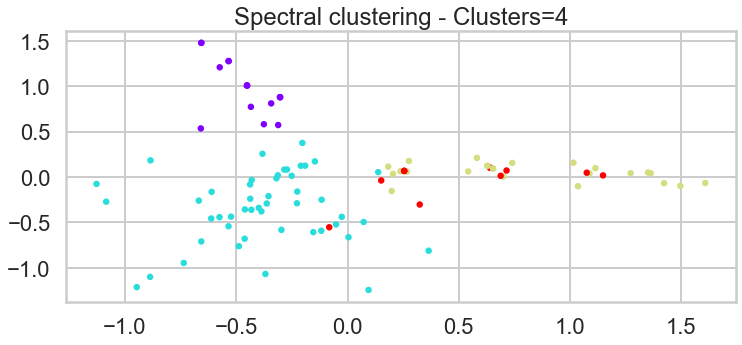

In [95]:
plt.subplots(figsize=(12, 5))
plt.scatter(p_comp1, p_comp2, c=clustering_sc_4.labels_, s=20, marker='o', cmap='rainbow')
plt.title('Spectral clustering - Clusters=4')

As shown above, when using <code>**n_clusters=4**</code>, we see 2 clusters with lots of overlaping points, however when using <code>**n_clusters=3**</code> looks like we have something to try:

In [96]:
#initialize and train our model
sc_3 = SpectralClustering(n_clusters=3, random_state=2018) # default n_clusters=8

clustering_sc_3 = sc_3.fit(pivoted)

Text(0.5, 1.0, 'Spectral clustering - Clusters=3')

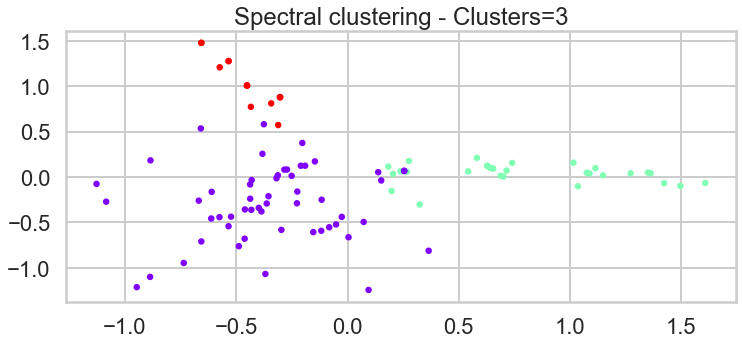

In [97]:
plt.subplots(figsize=(12, 5))
plt.scatter(p_comp1, p_comp2, c=clustering_sc_3.labels_, s=20, marker='o', cmap='rainbow')
plt.title('Spectral clustering - Clusters=3')

In [99]:
df_sc_3 = pd.DataFrame()
df_sc_3['customer_name'] = pivoted.index.values
df_sc_3['cluster'] = clustering_sc_3.labels_

df_sc_3.head(15)

,customer_name,cluster
0,Adams,1
1,Allen,0
2,Anderson,2
3,Bailey,1
4,Baker,0
5,Barnes,0
6,Bell,2
7,Bennett,1
8,Brooks,0
9,Brown,1


In [100]:
# now let's merge clusters to the main dataframe merged:
df_new_sc = df_sc_3.merge(merged, on='customer_name', how='right')
df_new_sc

,customer_name,cluster,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak
0,Smith,2,2,1,January,Pinot Noir,72,17,France,False
1,Smith,2,24,1,September,Pinot Noir,6,34,Italy,False
2,Rodriguez,2,2,1,January,Pinot Noir,72,17,France,False
3,Rodriguez,2,26,1,October,Pinot Noir,144,83,Australia,False
4,Martin,0,2,1,January,Pinot Noir,72,17,France,False
...,...,...,...,...,...,...,...,...,...,...
319,Ward,0,4,1,February,Champagne,72,48,France,True
320,Allen,0,9,1,April,Chardonnay,144,57,Chile,False
321,Allen,0,27,1,October,Champagne,72,88,New Zealand,False
322,Ramirez,0,9,1,April,Chardonnay,144,57,Chile,False


In [101]:
#let's save the data so we review and analyze using Tableau to see if we can get any insights:
df_new_sc.to_csv(path_or_buf = 'C:/Users/aktha/Desktop/Future/GOALLLLL/1602764303_Clustering_Case_Study_updated_10_15_2020' + "/sc_wine_final_3.csv", index=False)

### 7.3 Agglomerative clustering

Recursively merges the pair of clusters that minimally increases a given linkage distance.

In [76]:
#initialize and train our model
agg = AgglomerativeClustering(n_clusters=4, linkage="average", affinity="cosine") # default n_clusters=2

clustering_agg = agg.fit(pivoted)

Text(0.5, 1.0, 'Agglomerative clustering')

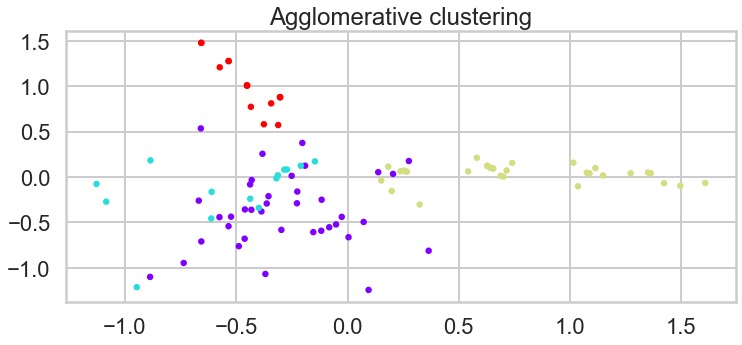

In [83]:
plt.subplots(figsize=(12, 5))
plt.scatter(p_comp1, p_comp2, c=clustering_agg.labels_, s=20, marker='o', cmap='rainbow')
plt.title('Agglomerative clustering')

As shown above, we see 2 clusters with lots of overlaping points, thats why we pass on this one, NEXT!!!

### 7.4 Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

Perform DBSCAN clustering from vector array or distance matrix.

DBSCAN - Density-Based Spatial Clustering of Applications with Noise. Finds core samples of high density and expands clusters from them. Good for data which contains clusters of similar density.

In [79]:
#initialize and train our model
dbs = DBSCAN() # default n_clusters=2

clustering_dbs = dbs.fit(pivoted)

Text(0.5, 1.0, 'Density-Based Spatial Clustering of Applications with Noise')

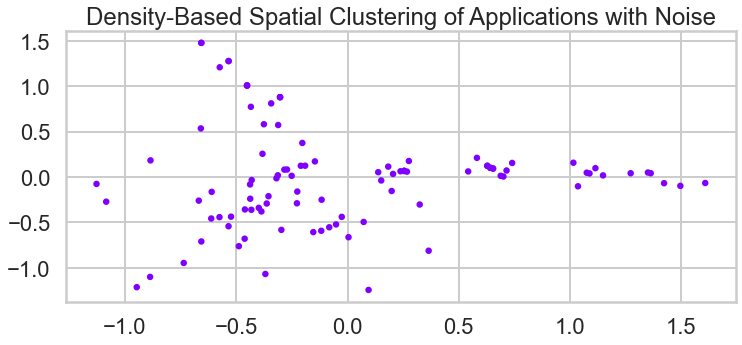

In [85]:
plt.subplots(figsize=(12, 5))
plt.scatter(p_comp1, p_comp2, c=clustering_dbs.labels_, s=20, marker='o', cmap='rainbow')
plt.title('Density-Based Spatial Clustering of Applications with Noise')

This one results in in just one cluster which is the opposite of what we're trying to accomplish here:)
for our dataset the best option so far is Kmeans

<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>

[Source](http://scikit-learn.org/stable/modules/clustering.html)